<a href="https://colab.research.google.com/github/ilhanaydintr/AttentionCNN-/blob/main/attention_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import IPython.display as display

class ConvPart(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1a = nn.Conv2d(3, 32, 5, padding=2)
        self.p1 = nn.MaxPool2d(2)
        self.c2a = nn.Conv2d(32, 32, 5, padding=2)
        self.p2 = nn.MaxPool2d(2)
        self.c3 = nn.Conv2d(32, 32, 5, padding=2)
        self.bn1a = nn.BatchNorm2d(32)
        self.bn2a = nn.BatchNorm2d(32)

    def forward(self, x):
        z = self.bn1a(F.leaky_relu(self.c1a(x)))
        z = self.p1(z)
        z = self.bn2a(F.leaky_relu(self.c2a(z)))
        z = self.p2(z)
        z = self.c3(z)
        return z
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvPart()
        self.final = nn.Linear(32, 1)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        z = self.conv(x)
        z = z.mean(3).mean(2)
        p = torch.sigmoid(self.final(z))[:, 0]
        return p, _

class NetMultiheadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvPart()
        self.attn1 = MultiHeadAttention(n_head=4, d_model=32, d_k=8, d_v=8)
        self.final = nn.Linear(32, 1)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        z = self.conv(x)
        q = torch.reshape(z, (z.size(0), -1 , z.size(1)))
        q, w = self.attn1(q, q, q)
        q = torch.reshape(q, (z.size(0), z.size(1), z.size(2), z.size(3)))
        z = q.mean(3).mean(2)
        p = torch.sigmoid(self.final(z))[:, 0]
        return p, q

class NetCBAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvPart()
        self.attn1 = CBAM(gate_channels=32)
        self.final = nn.Linear(32, 1)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        z = self.conv(x)
        q = self.attn1(z)
        z = q.mean(3).mean(2)
        p = torch.sigmoid(self.final(z))[:, 0]
        return p, q

In [ ]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''
    def __init__(self, temperature, attn_dropout=0.0):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        return output, attn


In [ ]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)
        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.
        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn

In [ ]:

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=True):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

query = torch.rand(128, 256, 24, 24)
attn = CBAM(gate_channels=256)
attn_output = attn(query)
print(attn_output.size())

torch.Size([128, 256, 24, 24])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from torchvision.datasets import STL10

dataset = STL10("stl10", split='train', download=True)
def getBatch(BS=10, offset=0, display_labels=False):
    xs = []
    labels = []
    for i in range(BS):
        x, y = dataset[offset + i]
        x = (np.array(x)-128.0)/128.0
        x = x.transpose(2, 0, 1)
        
        np.random.seed(i + 10)
        corrupt = np.random.randint(2)
        if corrupt:  # To corrupt the image, we'll just copy a patch from somewhere else
            pos_x = np.random.randint(96-16)
            pos_y = np.random.randint(96-16)
            x[:, pos_x:pos_x+16, pos_y:pos_y+16] = 1
        xs.append(x)
        labels.append(corrupt)

    if display_labels == True:
        print(labels)

    return np.array(xs), np.array(labels)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting stl10/stl10_binary.tar.gz to stl10


In [ ]:
class ConvPart(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1a = nn.Conv2d(3, 32, 5, padding=2)
        self.p1 = nn.MaxPool2d(2)
        self.c2a = nn.Conv2d(32, 32, 5, padding=2)
        self.p2 = nn.MaxPool2d(2)
        self.c3 = nn.Conv2d(32, 32, 5, padding=2)
        self.bn1a = nn.BatchNorm2d(32)
        self.bn2a = nn.BatchNorm2d(32)

    def forward(self, x):
        z = self.bn1a(F.leaky_relu(self.c1a(x)))
        z = self.p1(z)
        z = self.bn2a(F.leaky_relu(self.c2a(z)))
        z = self.p2(z)
        z = self.c3(z)
        return z
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvPart()
        self.final = nn.Linear(32, 1)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        z = self.conv(x)
        z = z.mean(3).mean(2)
        p = torch.sigmoid(self.final(z))[:, 0]
        return p, _

class NetMultiheadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvPart()
        self.attn1 = MultiHeadAttention(n_head=4, d_model=32, d_k=8, d_v=8)
        self.final = nn.Linear(32, 1)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        z = self.conv(x)
        q = torch.reshape(z, (z.size(0), -1 , z.size(1)))
        q, w = self.attn1(q, q, q)
        q = torch.reshape(q, (z.size(0), z.size(1), z.size(2), z.size(3)))
        z = q.mean(3).mean(2)
        p = torch.sigmoid(self.final(z))[:, 0]
        return p, q

class NetCBAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = ConvPart()
        self.attn1 = CBAM(gate_channels=32)
        self.final = nn.Linear(32, 1)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        z = self.conv(x)
        q = self.attn1(z)
        z = q.mean(3).mean(2)
        p = torch.sigmoid(self.final(z))[:, 0]
        return p, q

In [ ]:
device = 'cuda' if torch.cuda.is_available() else torch.device('cpu')
print(device)

def plot_without_attention(tr_err, ts_err, tr_acc, ts_acc, img):
    plt.clf()
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].plot(tr_err, label='tr_err')
    axs[0].plot(ts_err, label='ts_err')
    axs[0].legend()
    axs[1].plot(tr_acc, label='tr_err')
    axs[1].plot(ts_acc, label='ts_err')
    axs[1].legend()
    axs[2].axis('off')
    axs[3].axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

def plot_with_attention(tr_err, ts_err, tr_acc, ts_acc, img, att_out, no_images=6):
    plt.clf()
    fig, axs = plt.subplots(1+no_images, 4, figsize=(20, (no_images+1)*5))
    axs[0, 0].plot(tr_err, label='tr_err')
    axs[0, 0].plot(ts_err, label='ts_err')
    axs[0, 0].legend()
    axs[0, 1].plot(tr_acc, label='tr_err')
    axs[0, 1].plot(ts_acc, label='ts_err')
    axs[0, 1].legend()
    axs[0, 2].axis('off')
    axs[0, 3].axis('off')
    for img_no in range(6):
        im = img[img_no].cpu().detach().numpy().transpose(1, 2, 0)*0.5 + 0.5
        axs[img_no+1, 0].imshow(im)
        for i in range(3):
            att_out_img = att_out[img_no, i+1].cpu().detach().numpy()
            axs[img_no+1, i+1].imshow(att_out_img)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

def train(model, att_flag=False):
    net = model.to(device)
    BATCH_SIZE=10
    tr_err, ts_err = [], []
    tr_acc, ts_acc = [], []
    for epoch in range(50):
        errs, accs = [], []
        net.train()
        for i in range(4000//BATCH_SIZE):
            net.optim.zero_grad()
            x, y = getBatch(BATCH_SIZE, i*BATCH_SIZE)
            x = torch.FloatTensor(x).to(device)
            y = torch.FloatTensor(y).to(device)
            p, q = net.forward(x)
            loss = -torch.mean(y*torch.log(p+1e-8) + (1-y)*torch.log(1-p+1e-8))
            loss.backward()
            errs.append(loss.cpu().detach().item())
            pred = torch.round(p)
            accs.append(torch.sum(pred == y).cpu().detach().item()/BATCH_SIZE)
            net.optim.step()    
        tr_err.append(np.mean(errs))
        tr_acc.append(np.mean(accs))

        errs, accs = [], []
        net.eval()
        for i in range(1000//BATCH_SIZE):
            x, y = getBatch(BATCH_SIZE, i*BATCH_SIZE+4000)
            x = torch.FloatTensor(x).to(device)
            y = torch.FloatTensor(y).to(device)
            p, q = net.forward(x)            
            loss = -torch.mean(y*torch.log(p+1e-8) + (1-y)*torch.log(1-p+1e-8))
            errs.append(loss.cpu().detach().item())
            pred = torch.round(p)
            accs.append(torch.sum(pred == y).cpu().detach().item()/BATCH_SIZE)
        ts_err.append(np.mean(errs))  
        ts_acc.append(np.mean(accs))
        
        if att_flag == False:
            plot_without_attention(tr_err, ts_err, tr_acc, ts_acc, x[0])
        else:
            plot_with_attention(tr_err, ts_err, tr_acc, ts_acc, x, q)
        
        print(f'Min train error: {np.min(tr_err)}')
        print(f'Min test error: {np.min(ts_err)}')

cuda


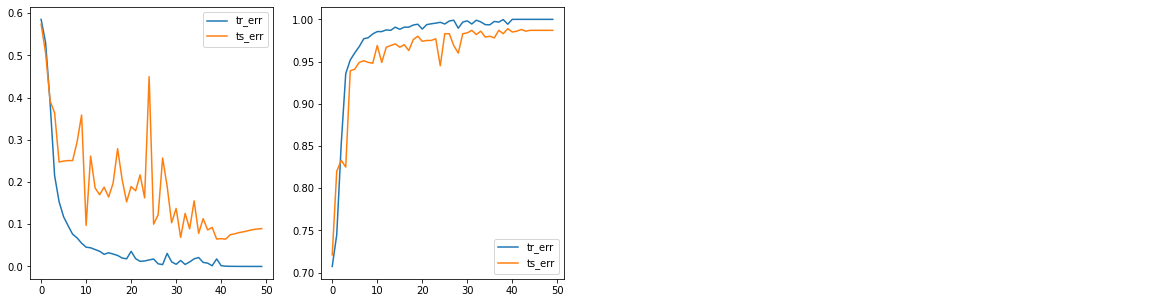

Min train error: 7.857583434011772e-05
Min test error: 0.06468625972674999


<Figure size 432x288 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

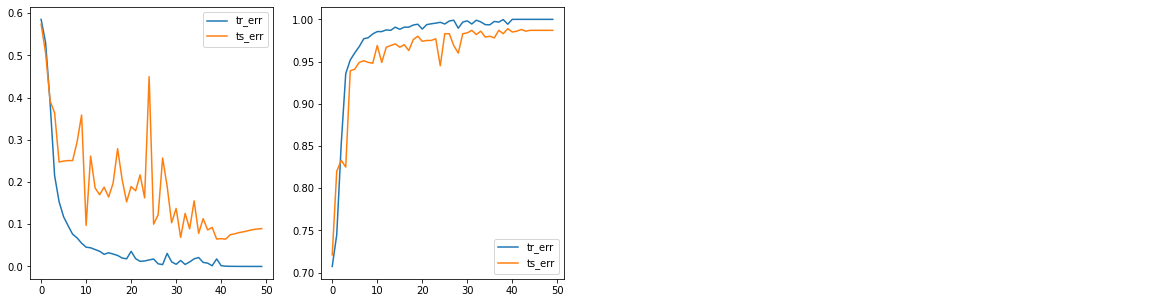

In [ ]:
model = Net()
train(model, att_flag=False)

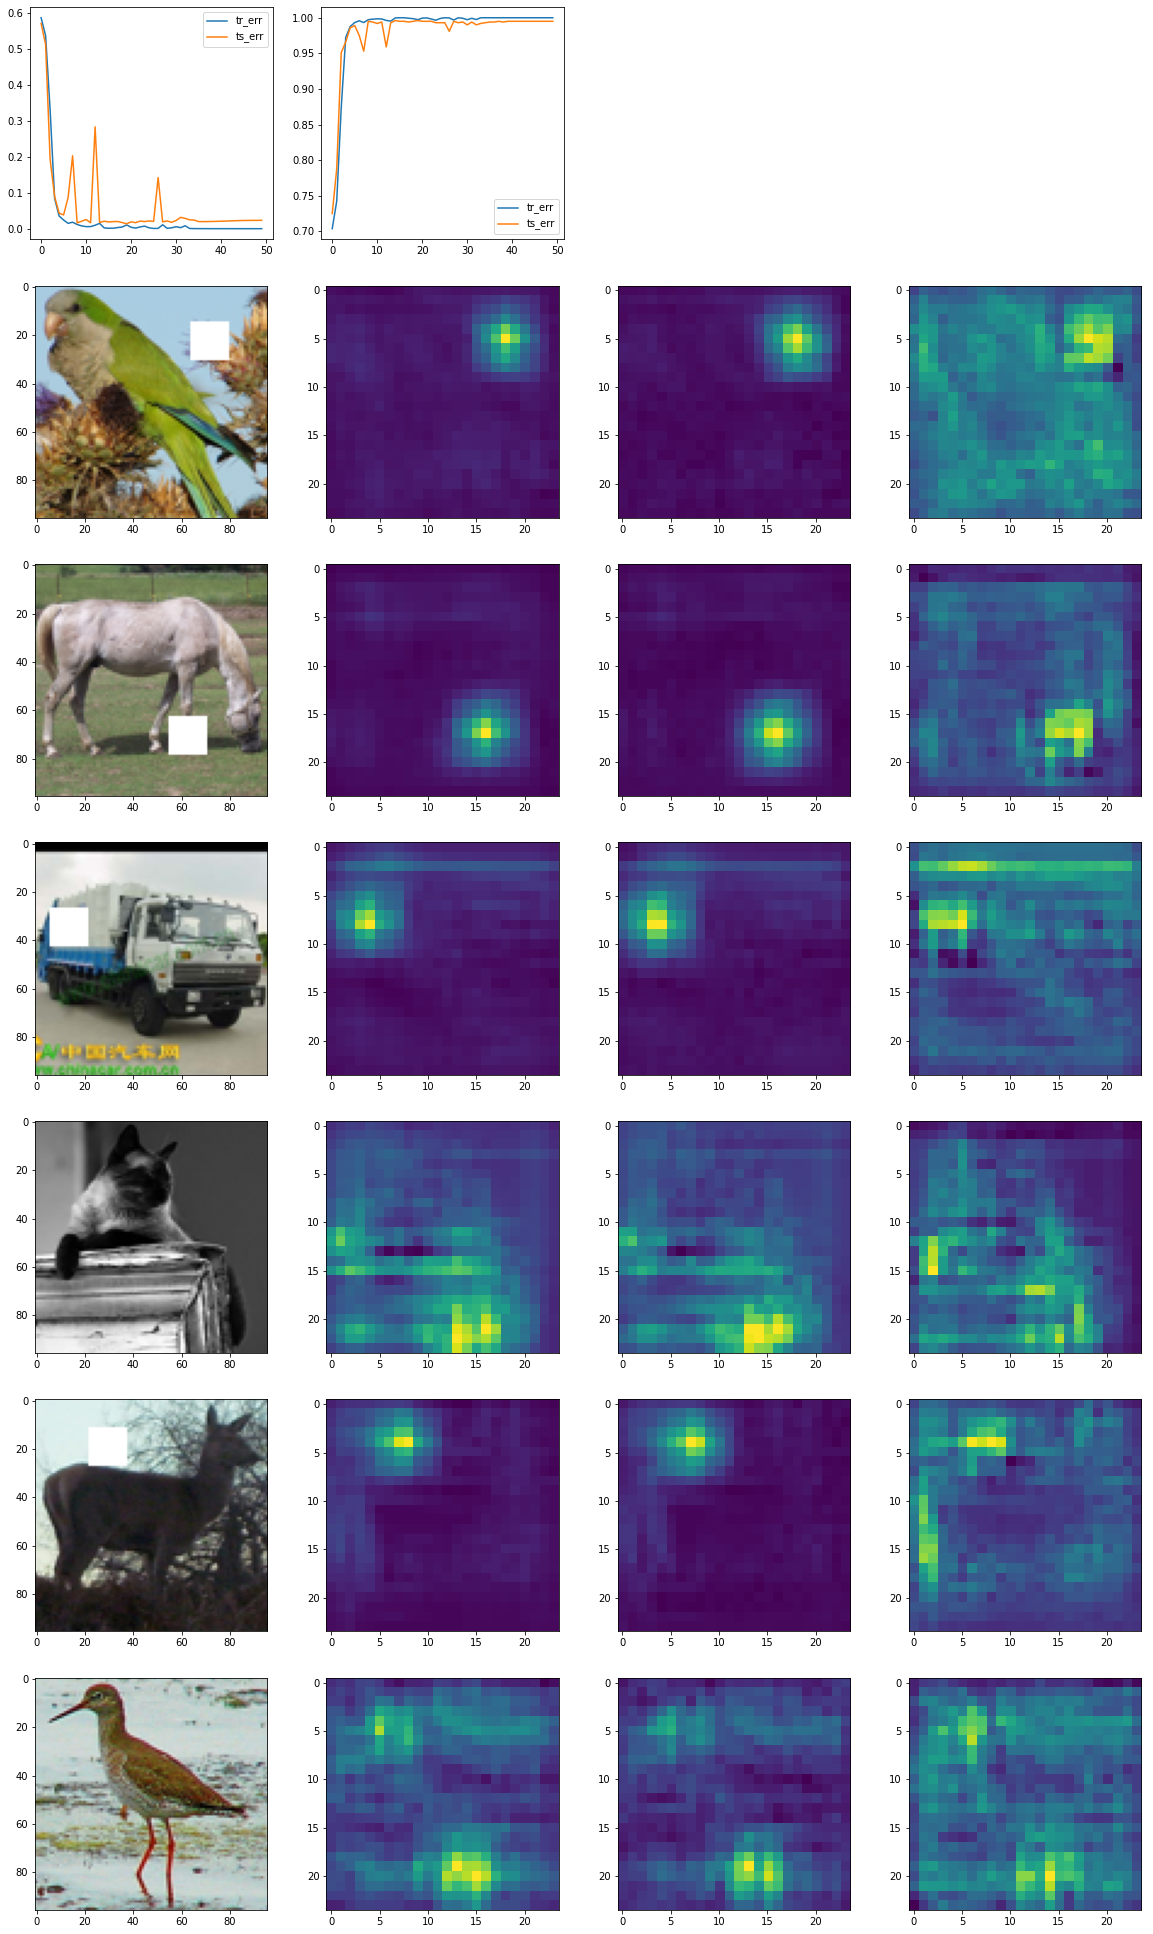

Min train error: 7.730809723085486e-06
Min test error: 0.013585048432287295


<Figure size 432x288 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

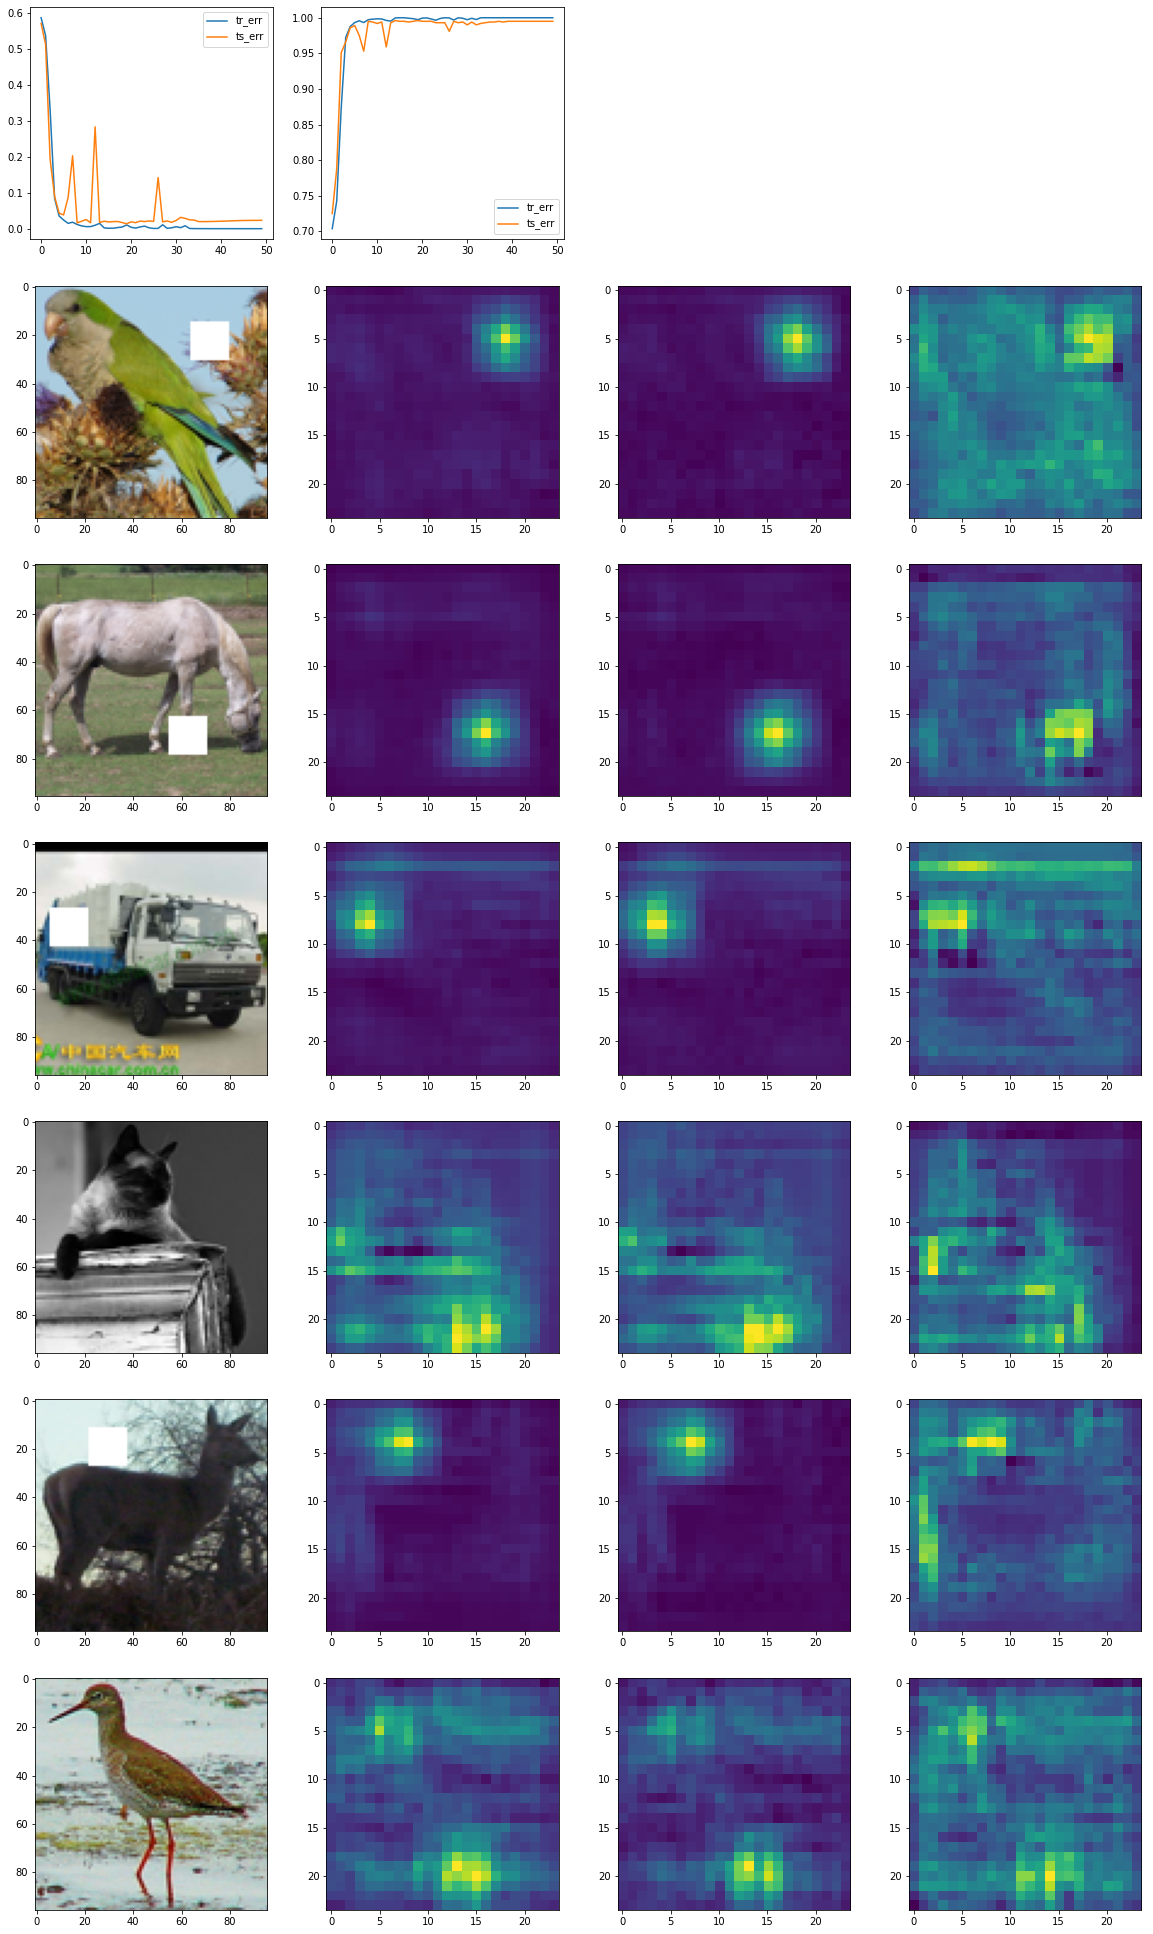

In [ ]:
model = NetCBAM()
train(model, att_flag=True)

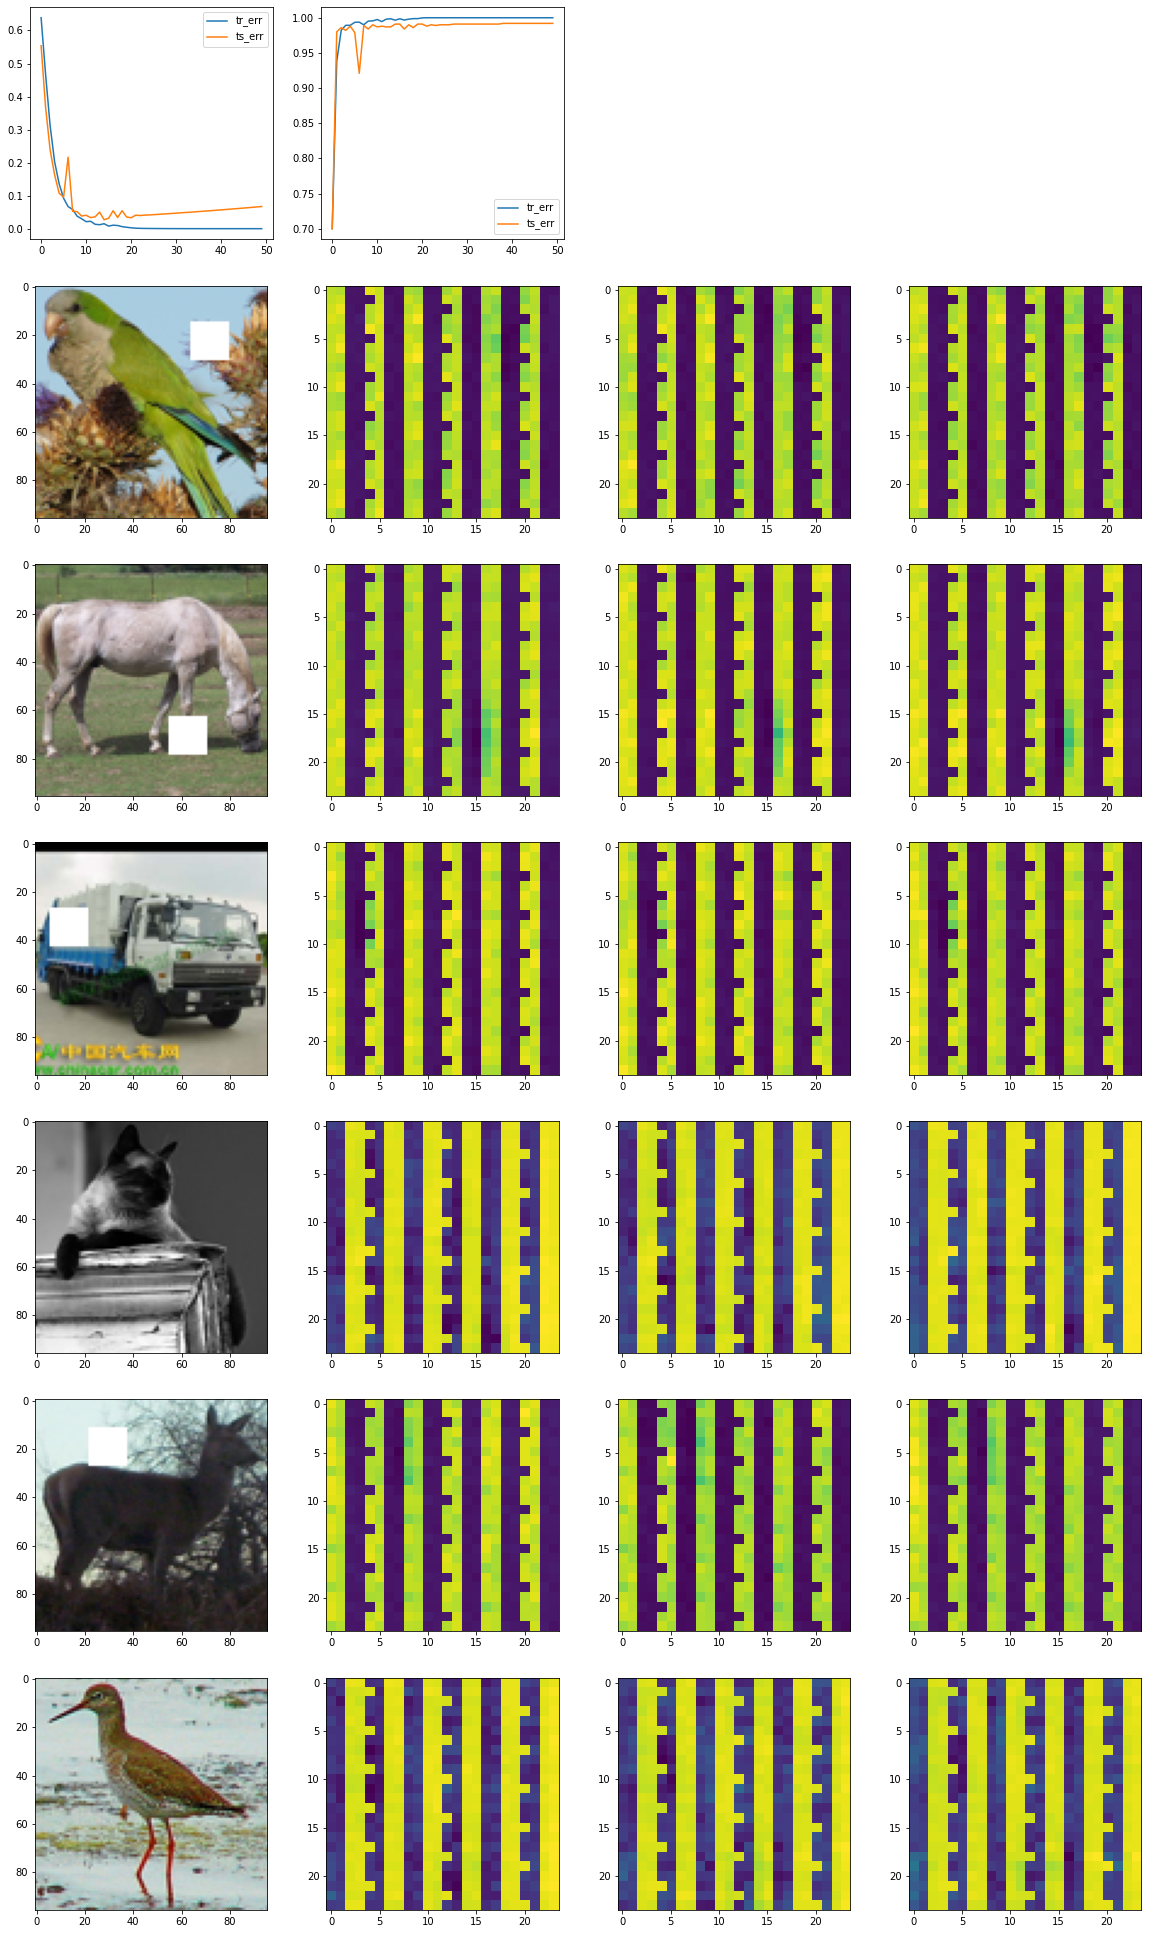

Min train error: 2.625649472633995e-06
Min test error: 0.0270669948682189


<Figure size 432x288 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

<Figure size 1440x2520 with 0 Axes>

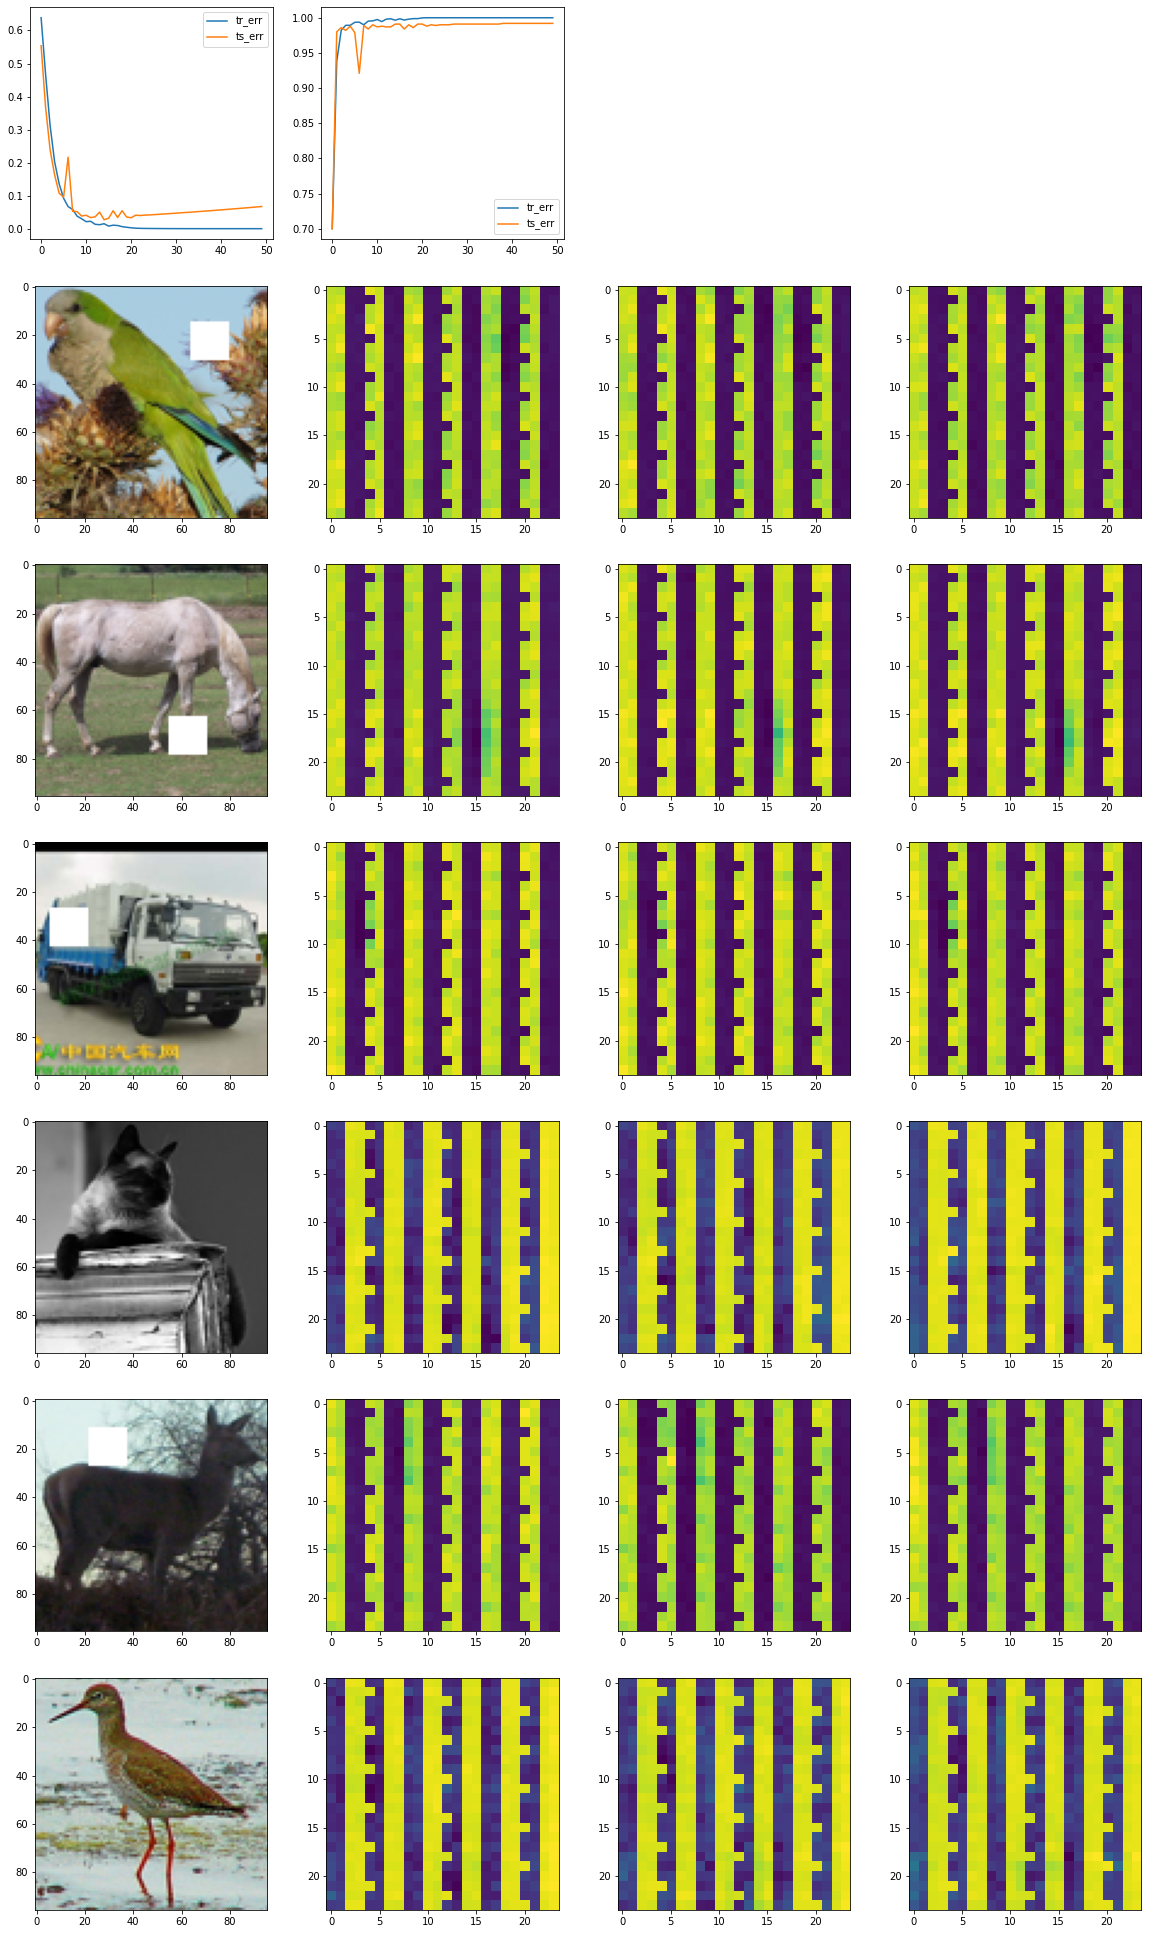

In [ ]:
model = NetMultiheadAttention()
train(model, att_flag=True)